In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, Reshape, Multiply
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os


2024-10-24 12:17:05.509515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 12:17:11.456627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 12:17:11.476372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 12:17:22.277322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# Set directories
train_folder = "Data/train"
valid_folder = "Data/valid"
test_folder = "Data/test"


In [3]:

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Data augmentation
train_datagen = ImageDataGenerator(
    dtype='float32',
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(dtype='float32')
test_datagen = ImageDataGenerator(dtype='float32')


In [4]:

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical'
)


Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [6]:

# Define squeeze-and-excitation block
def squeeze_excitation_block(input, ratio=16):
    init = input
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = Multiply()([init, se])
    return x

# Define residual block
def residual_block(x, filters, kernel_size, stride):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Load VGG16 model
input_tensor = Input(shape=input_shape)
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Add custom layers on top
x = vgg16.output
x = residual_block(x, 512, 3, 1)
x = residual_block(x, 512, 3, 1)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=vgg16.input, outputs=predictions)
# model.summary()


In [7]:

# Compile the model
optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Change this based on your system's capacity
    verbose=1
)


Epoch 1/10
10/10 [==============================] - 363s 37s/step - loss: 1.2789 - accuracy: 0.4910 - val_loss: 10.7716 - val_accuracy: 0.1806
Epoch 2/10
10/10 [==============================] - 371s 37s/step - loss: 1.0184 - accuracy: 0.5498 - val_loss: 13.4577 - val_accuracy: 0.1806
Epoch 3/10
10/10 [==============================] - 371s 37s/step - loss: 0.9485 - accuracy: 0.5563 - val_loss: 7.5239 - val_accuracy: 0.1806
Epoch 4/10
10/10 [==============================] - 370s 37s/step - loss: 0.8099 - accuracy: 0.6786 - val_loss: 1.8333 - val_accuracy: 0.3056
Epoch 5/10
10/10 [==============================] - 368s 37s/step - loss: 0.6617 - accuracy: 0.7210 - val_loss: 2.1428 - val_accuracy: 0.4583
Epoch 6/10
10/10 [==============================] - 368s 37s/step - loss: 0.6475 - accuracy: 0.7194 - val_loss: 1.4318 - val_accuracy: 0.5417
Epoch 7/10
10/10 [==============================] - 367s 37s/step - loss: 0.5336 - accuracy: 0.7716 - val_loss: 0.9176 - val_accuracy: 0.6667
Epoc

In [17]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')


5/5 [==============================] - 52s 11s/step - loss: 0.6265 - accuracy: 0.7397
Test accuracy: 0.7396825551986694


In [18]:

# Predictions
predicted_probabilities = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = test_generator.classes


5/5 [==============================] - 50s 11s/step


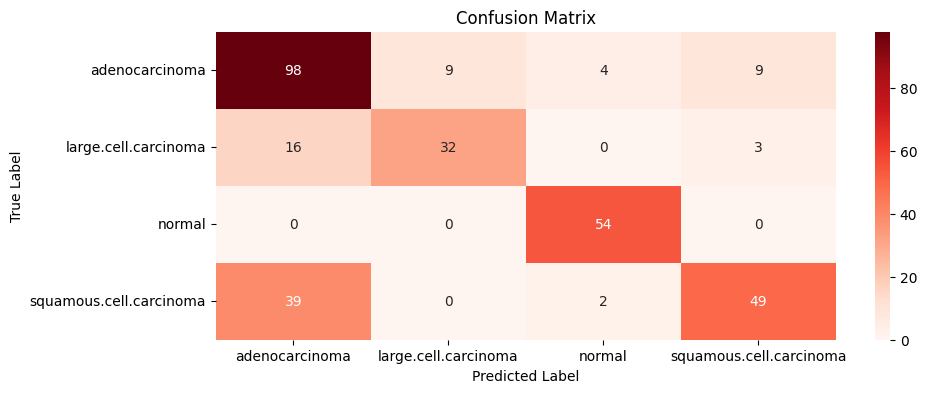

In [19]:

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


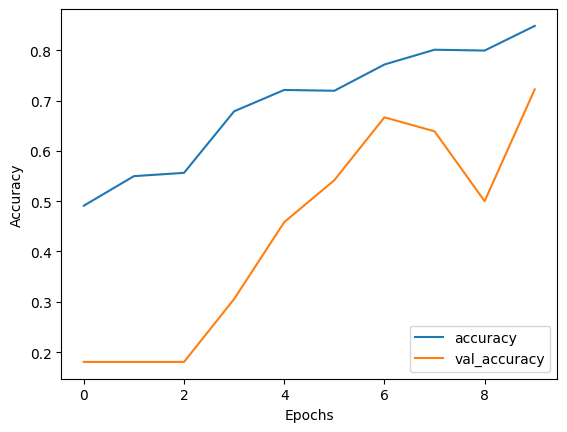

In [20]:

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


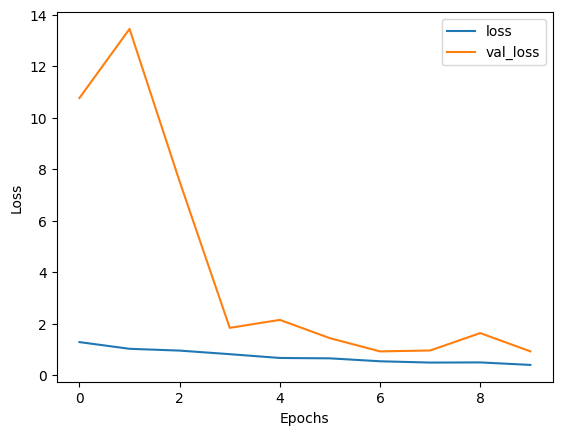

In [21]:

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [22]:

# Classification report
report = classification_report(true_labels, predicted_labels)
print(report)


              precision    recall  f1-score   support

           0       0.64      0.82      0.72       120
           1       0.78      0.63      0.70        51
           2       0.90      1.00      0.95        54
           3       0.80      0.54      0.65        90

    accuracy                           0.74       315
   macro avg       0.78      0.75      0.75       315
weighted avg       0.75      0.74      0.73       315

